In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pml = pd.read_csv('pml_train.csv')
pml.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,0,A,A,A,A,B,A,A,A,A,...,0.669748,0.515940,0.55421,0.53774,0.47225,0.492200,0.481306,0.756454,0.344502,2152.80
1,1,B,A,A,A,A,B,A,A,A,...,0.484775,0.698278,0.35533,0.40657,0.40666,0.468839,0.458493,0.304350,0.470455,1019.89
2,2,A,A,A,B,A,A,A,A,A,...,0.350956,0.363768,0.58354,0.44352,0.39599,0.341813,0.352251,0.339244,0.283969,4477.83
3,3,B,A,A,A,A,B,A,A,A,...,0.748243,0.538694,0.54829,0.50420,0.51111,0.711942,0.698722,0.709578,0.776114,907.11
4,4,A,B,A,A,A,A,A,A,B,...,0.321058,0.326430,0.31280,0.39648,0.38016,0.245410,0.241676,0.261150,0.342082,974.62


In [3]:
pml_train_y = pml.loss
pml_train_X = pml.drop(columns=['id', 'loss'])
pml_train_X.shape

(131822, 130)

In [4]:
pml_train_d_X = pd.get_dummies(pml_train_X)
pml_train_d_X.shape

(131822, 1111)

In [5]:
pml_test = pd.read_csv('pml_test_features.csv')
pml_test_X = pml_test.drop(columns=['id'])
pml_test_X.shape

(56496, 130)

In [6]:
# one-hot encoded test
pml_test_d_X = pd.get_dummies(pml_test)
pml_test_d_X.shape

(56496, 1066)

In [7]:
cDrop = [c for c in pml_test_d_X.columns if c not in pml_train_d_X.columns]
print(cDrop)
pml_test_d_X.drop(columns = cDrop, inplace=True)

for c in pml_train_d_X.columns:
    if c not in pml_test_d_X.columns:
        pml_test_d_X[c] = 0
print(pml_test_d_X.shape)
pml_test_d_X.head()

['id', 'cat75_C', 'cat89_H', 'cat92_F', 'cat99_O', 'cat101_H', 'cat102_H', 'cat103_N', 'cat105_T', 'cat107_S', 'cat109_AG', 'cat109_BF', 'cat109_BT', 'cat109_BV', 'cat109_CB', 'cat109_J', 'cat110_AS', 'cat110_BD', 'cat110_BK', 'cat110_BM', 'cat110_CB', 'cat110_DV', 'cat113_P', 'cat114_G', 'cat116_AH', 'cat116_AM', 'cat116_AN', 'cat116_AP', 'cat116_AT', 'cat116_EQ', 'cat116_EV', 'cat116_FI', 'cat116_FJ', 'cat116_FN', 'cat116_FO', 'cat116_HU', 'cat116_IO', 'cat116_IV', 'cat116_J', 'cat116_JA', 'cat116_JI', 'cat116_JN', 'cat116_MB']
(56496, 1111)


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cat116_MH,cat116_MS,cat116_MT,cat116_MV,cat116_O,cat116_Q,cat116_R,cat116_S,cat116_V,cat116_W
0,0.474338,0.488789,0.634224,0.844287,0.491114,0.417611,0.347261,0.58354,0.50630,0.39068,...,0,0,0,0,0,0,0,0,0,0
1,0.907272,0.737068,0.336963,0.738221,0.380560,0.843479,0.502621,0.94403,0.93383,0.83510,...,0,0,0,0,0,0,0,0,0,0
2,0.899689,0.620805,0.484196,0.594598,0.794794,0.808958,0.478205,0.72299,0.94438,0.83510,...,0,0,0,0,0,0,0,0,0,0
3,0.330514,0.737068,0.613660,0.473202,0.908217,0.240069,0.283691,0.24564,0.30859,0.32446,...,0,0,0,0,0,0,0,0,0,0
4,0.480125,0.358319,0.484196,0.373816,0.674529,0.317735,0.362399,0.26847,0.41471,0.43919,...,0,0,0,0,0,0,0,0,0,0


In [8]:
pml_train_cont = pml_train_X.filter(regex=("cont\d*"))
pml_train_cont.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.480125,0.358319,0.215772,0.713852,0.577339,0.669748,0.515940,0.55421,0.53774,0.47225,0.492200,0.481306,0.756454,0.344502
1,0.351358,0.681761,0.777587,0.182950,0.281143,0.484775,0.698278,0.35533,0.40657,0.40666,0.468839,0.458493,0.304350,0.470455
2,0.497513,0.737068,0.549770,0.452887,0.499798,0.350956,0.363768,0.58354,0.44352,0.39599,0.341813,0.352251,0.339244,0.283969
3,0.452710,0.488789,0.506105,0.473202,0.281143,0.748243,0.538694,0.54829,0.50420,0.51111,0.711942,0.698722,0.709578,0.776114
4,0.434106,0.358319,0.419161,0.838840,0.491114,0.321058,0.326430,0.31280,0.39648,0.38016,0.245410,0.241676,0.261150,0.342082


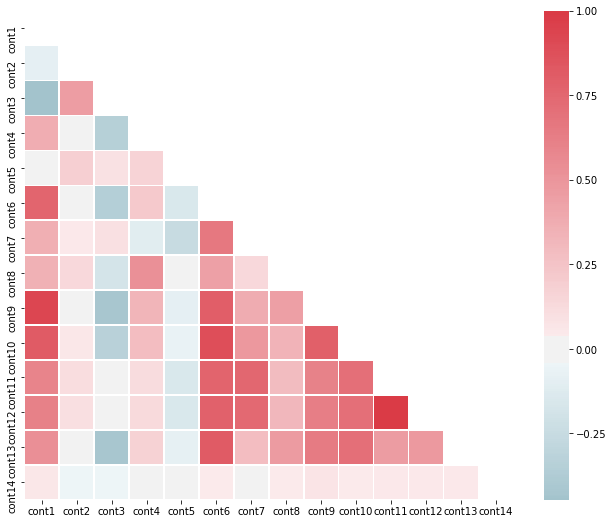

In [9]:
#Generate a correlation matrix between features
x_corr = pml_train_cont.corr()
mask = np.zeros_like(x_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(x_corr, mask=mask, vmax=1, cmap=cmap, center=0,
            square=True, linewidths=.5)

In [10]:
pml_train_c_X = pml_train_X.copy()

In [18]:
def col_op(col):
    return col.astype('category').cat.codes

In [32]:
def digit_op(code):
    num = 0
    for alpha in code:
        num *= 26
        num += ord(alpha) - ord('A') + 1
    return num

def to_digit(col):
    return col.apply(digit_op)

In [37]:
to_digit(['AA','BB','A'])

AttributeError: 'list' object has no attribute 'apply'

In [12]:
tmp = pml_train_X.select_dtypes(exclude='float64')
# tmp = pd.Categorical(tmp)

pml_train_c_X.loc[:, tmp.columns] = tmp.apply(lambda col: col.astype('category').cat.codes)

In [13]:
pml_train_c_X.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,0,0,0,1,0,0,0,0,0,...,0.577339,0.669748,0.515940,0.55421,0.53774,0.47225,0.492200,0.481306,0.756454,0.344502
1,1,0,0,0,0,1,0,0,0,0,...,0.281143,0.484775,0.698278,0.35533,0.40657,0.40666,0.468839,0.458493,0.304350,0.470455
2,0,0,0,1,0,0,0,0,0,0,...,0.499798,0.350956,0.363768,0.58354,0.44352,0.39599,0.341813,0.352251,0.339244,0.283969
3,1,0,0,0,0,1,0,0,0,0,...,0.281143,0.748243,0.538694,0.54829,0.50420,0.51111,0.711942,0.698722,0.709578,0.776114
4,0,1,0,0,0,0,0,0,1,0,...,0.491114,0.321058,0.326430,0.31280,0.39648,0.38016,0.245410,0.241676,0.261150,0.342082


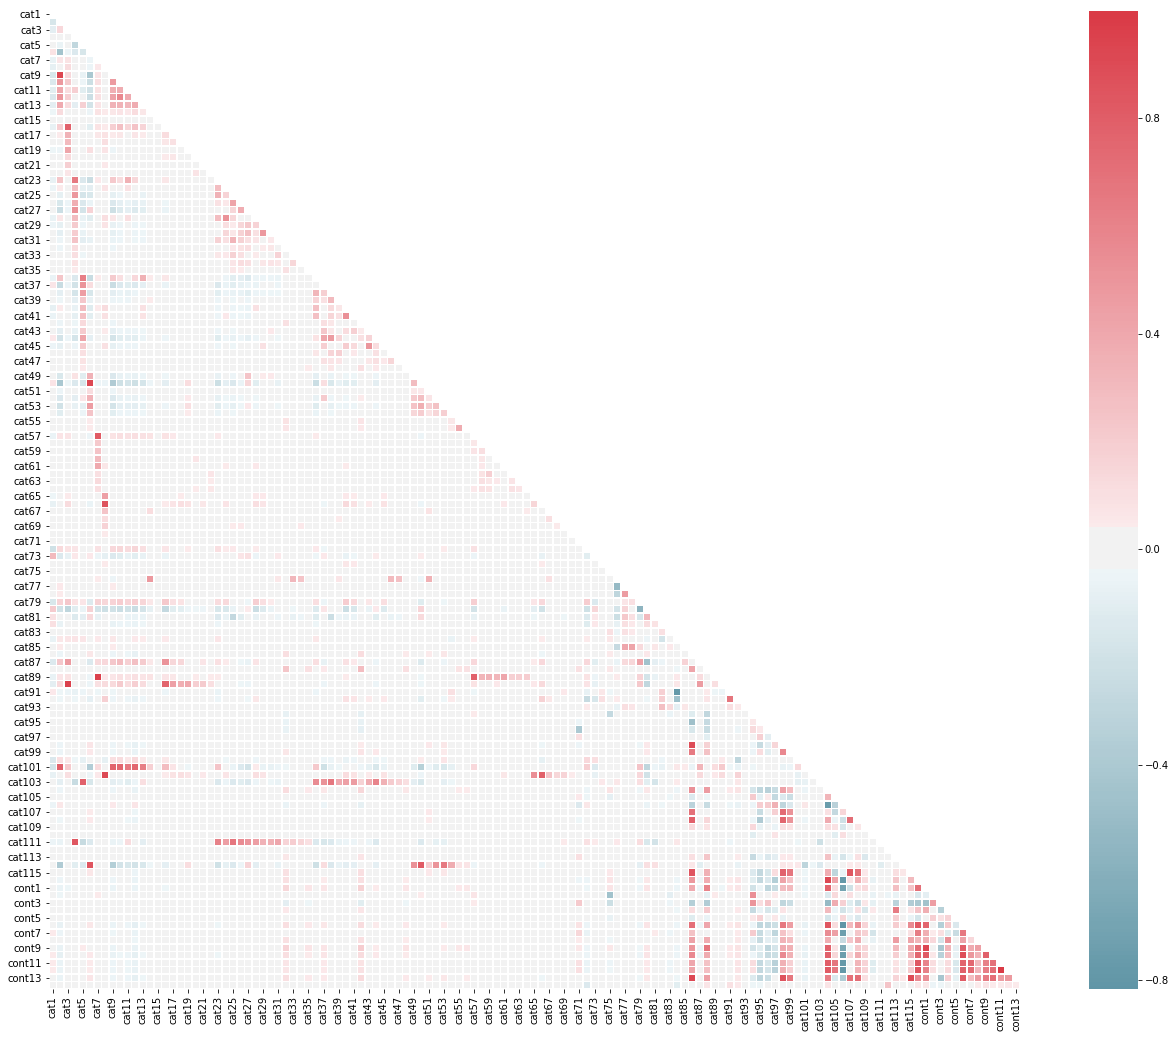

In [14]:
#Generate a correlation matrix between features
x_corr = pml_train_c_X.corr()
mask = np.zeros_like(x_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(x_corr, mask=mask, vmax=1, cmap=cmap, center=0,
            square=True, linewidths=.5)

## tree

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = RandomForestRegressor(n_estimators=10,criterion = 'mae',
                             max_leaf_nodes = 5, random_state = 2018)
regr.fit(pml_train_c_X, pml_train_y)

In [ ]:
regr.score(pml_train_c_X, pml_train_y)

In [14]:
from sklearn import tree

In [15]:
dt_clf = tree.DecisionTreeRegressor()
dt_clf = dt_clf.fit(pml_train_c_X, pml_train_y)

In [16]:
dt_clf.score(pml_train_c_X, pml_train_y)

0.9999999902035116

In [17]:
dt_ans = dt_clf.predict(pml_test_c_X, pml_train_y)

NameError: name 'pml_test_c_X' is not defined

In [ ]:
pd.DataFrame({'id':pml['id'], 
          'loss':dt_ans}).to_csv('./dt.csv',index = False)

In [ ]:
c = 'AB'

In [ ]:
for a in reversed(c):
    print(a)

In [30]:
temp = pd.DataFrame({'a':['A','B','C','B'],
             'b':['DC','BD','BF','CC']})
temp

,a,b
0,A,DC
1,B,BD
2,C,BF
3,B,CC


In [31]:
def op(col):
    return col.astype('category').cat.codes

In [39]:
# uniques = np.sort(pd.unique(temp.values.ravel()))
# temp.apply(lambda x: x.astype('category', categories=uniques))

le = LabelEncoder()
le.fit(temp.values.flat)

# Convert to digits.
temp = temp.apply(le.transform)
temp

NameError: name 'LabelEncoder' is not defined